The measured and model response matrices are defined by

$$\begin{pmatrix} x \\ y \end{pmatrix} = M_{meas,model} \begin{pmatrix} \theta_x \\ \theta_y \end{pmatrix}$$
where $\theta_x$and $\theta_y$  are the changes in steering magnet strengths,
and x , y are the resulting orbit perturbations.

The parameters in the used model is varied by LOCO to minimize the $ \chi^2 $ deviation between the model
and measured orbit response matrices $M_{model}$ and $M_{measured}$
$$  \chi^2 = \sum_{i,j} \frac{(M_{model,i,j}-M_{measured,i,j})^2}{\sigma^2_{i}} = \sum_{i,j} E_{k=(i,j)}^2 $$

The $\chi^2$ minimization is achieved by iteratively solving the linear equation
$$E_{k}^{new}= E_k +\frac{\partial{E_k}}{\partial{k_l}} \Delta k_l =0$$
$$-E_k= \frac{\partial{E_k}}{\partial{k_l}} \Delta k_l$$


In [4]:
print(f"LOCO, AT version")
from at import *
from pylab import *
from at_modules import *
from at.load import load_mat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from random import random

LOCO, AT version


In [5]:
# The lattice

from lattice import *
ring=at.Lattice(ring1, energy=1)
ring.radiation_off()

In [6]:
elements.Quadrupole?

preparing twiss ..
Tunes=[0.35830786 0.36002871]
Chrom=[-2.65974451 -1.92722258]


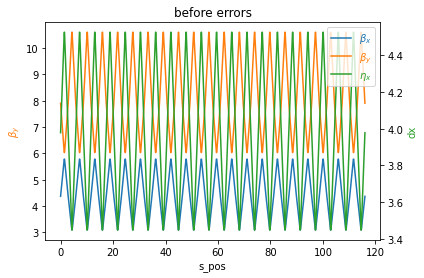

In [3]:
twiss = getOptics(ring, '*', 'beta', 'False')
make_plot(twiss, 'before errors')

(40, 40)


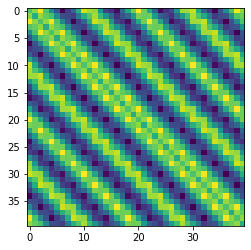

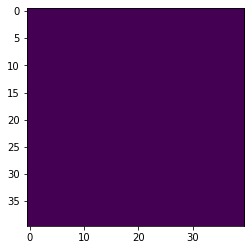

In [4]:
Cxx, Cxy= ORM_x(1.e-4, ring)
Cyy, Cyx= ORM_y(1.e-4, ring)

print(shape(Cxx))

plt.figure()
imshow(Cxx)
plt.show()

plt.figure()
imshow(Cxy)
plt.show()

In [5]:
%%time

quads_info = quad_info(ring)
quad_dict,quad_vals = getQuadFamilies(quads_info)
quads = [ k for k in quad_dict.keys()]

dk = 0.0001
qxx = []
qxy =[]
qyy = []
qyx =[]
quad_names = quads
for qname in quad_names:
    print('generating response to {}, n={}'.format(qname, quad_dict[qname]))
    nq = quad_dict[qname]+1
    for i in range(0,nq):
       Qxx, Qxy, Qyy, Qyx = computeOpticsD(ring, qname, i, dk, quad_vals)
       qxx.append(Qxx)
       qxy.append(Qxy)
       qyy.append(Qyy)
       qyx.append(Qyx)

Done...
generating response to QF, n=19
generating response to QD, n=19
Wall time: 40.2 s


In [6]:
C0x = Cxx
C0y = Cyy
C0xy = Cxy
C0yx = Cyx

dCx = []
dCy = []
dCxy = []
dCyx = []
quad_names = quads
for qname in quad_names:
#nquad = quad_dict[qname]
    print('loading response to:',qname)
i = 0
while(i<len(qxx)):

    C1x = qxx[i]
    C1y = qyy[i]
    C1xy = qxy[i]
    C1yx = qyx[i]
    dcxx = ( (C1x-C0x)  / dk)
    dcyy = ( (C1y-C0y) /dk)

    dCxy.append( (C1xy-C0xy)/ dk)
    dCyx.append( (C1yx-C0yx)/ dk)

    dCx.append(dcxx)
    dCy.append(dcyy)

    i += 1

loading response to: QF
loading response to: QD


simulating perturbed machine...
Done...
preparing twiss ..
Tunes=[0.38459454 0.39893504]
Chrom=[-2.70542864 -2.02537965]


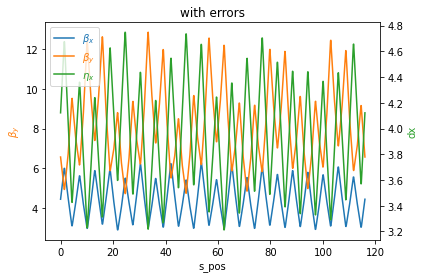

In [7]:
## simulate_errors

errorQF = 72.e-3
errorQD = 52.e-3
tiltQF = 3.e-3
tiltQD = 3.e-3

quads_info_error = simulateError_tilt(ring,errorQF,errorQD,tiltQF ,tiltQD)
twiss_error = getOptics(ring, '*', 'beta', 'True')
make_plot(twiss_error, 'with errors')

In [8]:
# ORM Cx, Cy

Cxx_err, Cxy_err= ORM_x_error(1.e-4, ring)
Cyy_err, Cyx_err= ORM_y_error(1.e-4, ring)

print(shape(Cxx_err))

(40, 40)


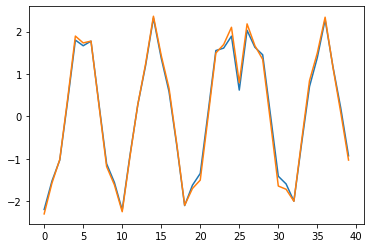

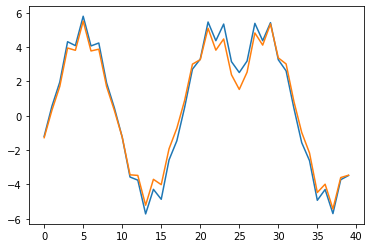

In [9]:
plt.plot(Cxx_err[25])
plt.plot((Cxx[25]))
plt.show()


plt.plot(Cyy[25])
plt.plot((Cyy_err[25]))
plt.show()

In [10]:
Nk = len(dCx) #number of free parameters
Nm = 40 # number of measurements
print('NK:', Nk)
print('Nm:', Nm)

Ax = np.zeros([Nk,Nk])
Ay = np.zeros([Nk,Nk])
Axy = np.zeros([Nk,Nk])
Ayx = np.zeros([Nk,Nk])

A = np.zeros([4*Nk,Nk])

##

Bx = np.zeros([Nk,1])
By = np.zeros([Nk,1])
Bxy = np.zeros([Nk,1])
Byx = np.zeros([Nk,1])

B = np.zeros([4*Nk,1])

##

Dx = (Cxx_err[0:Nm,:] - C0x[0:Nm,:]) ### dk ?
Dy = (Cyy_err[0:Nm,:] - C0y[0:Nm,:])
Dxy = (Cxy_err[0:Nm,:] - C0xy[0:Nm,:])
Dyx = (Cyx_err[0:Nm,:] - C0yx[0:Nm,:])

##

for i in range(Nk): ## i represents each quad
    #print('done A:', 100.* i ,'%')
    for j in range(Nk):
        Ax[i,j] = np.sum(np.dot(dCx[i],dCx[j].T) )
        Ay[i,j] = np.sum(np.dot(dCy[i],dCy[j].T) )
        Axy[i,j] = np.sum(np.dot(dCxy[i],dCxy[j].T) )
        Ayx[i,j] = np.sum(np.dot(dCyx[i],dCyx[j].T) )
    A[i,:] = Ax[i,:]
    A[i+Nk,:] = Ay[i,:]
    A[i+2*Nk,:] = Axy[i,:]
    A[i+3*Nk,:] = Ayx[i,:]

##

for i in range(Nk):
    Bx[i] = np.sum( np.dot(dCx[i], Dx.T) )
    By[i] = np.sum( np.dot(dCy[i], Dy.T) )
    Bxy[i] = np.sum( np.dot(dCxy[i], Dxy.T) )
    Byx[i] = np.sum( np.dot(dCyx[i], Dyx.T) )
    B[i] = Bx[i]
    B[i+Nk] = By[i]
    B[i+2*Nk] = Bxy[i]
    B[i+3*Nk] = Byx[i]

NK: 40
Nm: 40


number of singular values 40
A(160, 40) B(160, 1) U(160, 160) smat(160, 40) v(40, 40)


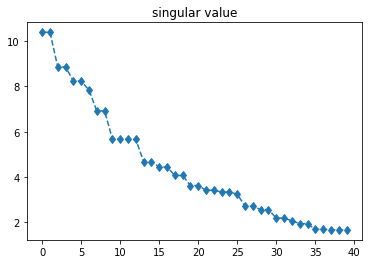

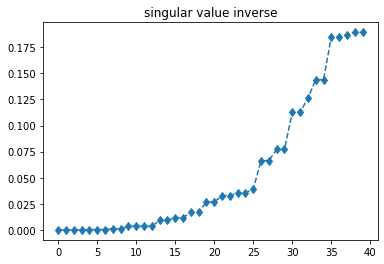

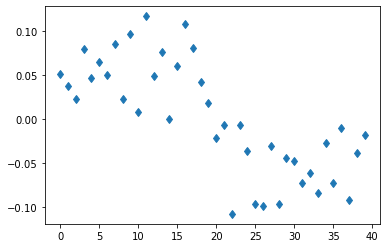

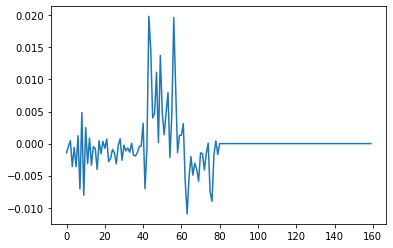

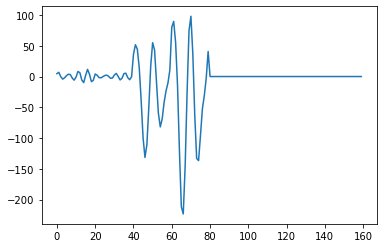

In [11]:
u,s,v=np.linalg.svd(A,full_matrices=True)

smat = 0.0 * A
si = s**-1
n_sv = 40
si[n_sv:] *= 0.0

print("number of singular values {}".format(len(si)))
smat[:Nk,:Nk] = np.diag(si)


print('A'+str(A.shape), 'B'+str(B.shape),'U'+str(u.shape), 'smat'+str(smat.shape), 'v'+str(v.shape))


plt.plot(np.log(s),'d--')
plt.title('singular value')
plt.show()

plt.plot(si,'d--')
plt.title('singular value inverse')
plt.show()

Ai=np.dot(v.transpose(),np.dot(smat.transpose(),u.transpose()))

###
r = ( np.dot(Ai,B)).reshape(-1)
plot(r,'d')
plt.show()


# error
e = np.dot(A,r).reshape(-1) - B.reshape(-1)
plt.plot(e)
plt.show()
plt.plot(B)
plt.show()

In [12]:
# check correction...
quad_dict,quad_vals = getQuadFamilies(quads_info_error)
n_list = len(quads_info_error.s_pos)
print(n_list)

quad_names = quad_names
iq = 0
frac = 1.0
cor_dict = {}
for qname in quad_names:
    nquad = quad_dict[qname]
    #print(qname, quad_dict[qname])
    for i in range(0, nquad):
        cor_dict[qname, i+1] = -r[iq]*frac
        iq += 1

40


In [13]:
DK = []
for idx in range(n_list):
   qname_ = quads_info.elements_name[idx]  # ElementName

   if qname_ == 'QF':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QF',occ]
      DK.append(dk)

   if qname_ == 'QD':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QD',occ]
      DK.append(dk)


   if qname_ == 'QS':
      occ = quads_info_error.occ[idx]
      dk = cor_dict['QS',occ]
      DK.append(dk)

quads_indexes = get_refpts(ring, elements.Quadrupole)
i = 0
while (i < len(quads_indexes)):
      ring[quads_indexes[i]].K += DK[i]
      i += 1

In [14]:
twiss_corrected = getOptics(ring, '*', 'beta', 'True')

preparing twiss ..
Tunes=[0.35810603 0.3599156 ]
Chrom=[-2.65949006 -1.92696009]


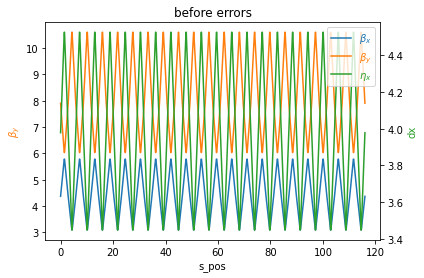

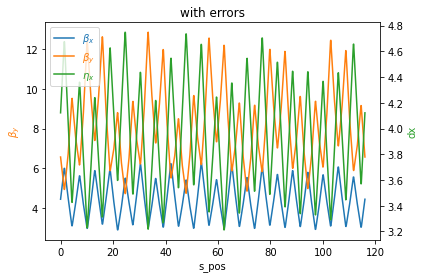

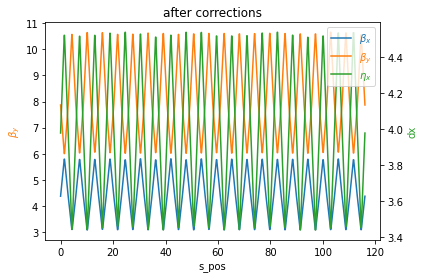

In [15]:
make_plot(twiss, 'before errors')
make_plot(twiss_error, 'with errors')
make_plot(twiss_corrected, 'after corrections')

In [16]:
getBetaBeat(twiss, twiss_error)
getBetaBeat(twiss, twiss_corrected)

getBetaBeat bx and by: 
Simulated beta beat, x:3.970465723831455%   y: 14.47331540911432%
getBetaBeat bx and by: 
Simulated beta beat, x:0.19780350685057782%   y: 0.23954291189735308%


Object `elements.Quadrupole` not found.
